In [1]:
import emcee
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial
import time

In [2]:
path_halo = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat1.fits'

path_amas = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags/zband/member_matching/fshare_0.1_pref_more_massive/cat2.fits'

t = Table.read(path_amas)

def table(path):
    with fits.open(path) as hdul:
        table = Table(hdul[1].data)
    return table

t_halo = table(path_halo)
t_amas = table(path_amas)
t_amas_match = t_amas[t_amas["mt_cross"] !='']

M = []
for id in t_amas_match["mt_cross"]:
    ligne = t_halo[t_halo["halo_id"] == id]
    M.append(ligne["m200c"][0])
t_amas_match["M"] = M
t_amas_match = t_amas_match[t_amas_match["snr"]>6]

def tableau_coupure_n200(coupure):
    return t_amas_match[t_amas_match["n200"]>coupure]
def tableau_bin_n200(binn):
    a, b = binn
    return t_amas_match[(t_amas_match["n200"]>a) & (t_amas_match["n200"]<b)]

Mp, zp = 10**14.3, 0.5


In [4]:
list_bin = np.array([(20, 40), (40, 60), (60, 80), (80, 100)])
table_bin = []
for binn in list_bin:
    table_bin.append(tableau_bin_n200(binn))

In [5]:
def prior(params):
    A, B, C, D, E, F = params
    if -2<C<2 or -2<E<2 or -2<F<2:
        return True
    else:
        return False

#X est le catalogue
def _ln_L(params, X, a, b):
    A, B, C, D, E, F = params
    prior_check = prior(params)
    if not prior_check:
        return -np.inf
    pop, M, z = np.log(X["n200"]), X["M"], X["zp"]
    mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
    sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    sigma = np.clip(sigma, 1e-5, None)
    #print("sigma max/min :", max(sigma), min(sigma))
    #log-Vraissemblance
    erf = lambda x: scipy.special.erf((np.log(x)-mean_alpha)/(sigma*2**0.5))
    correction = lambda a, b: erf(b)-erf(a)
    ln_L = - sum(np.log(sigma*(2*np.pi)**0.5)) - sum(0.5*((pop-mean_alpha)/sigma)**2) - sum(0.5*correction(a, b))
    return ln_L

0.0
25.0
50.0
75.0


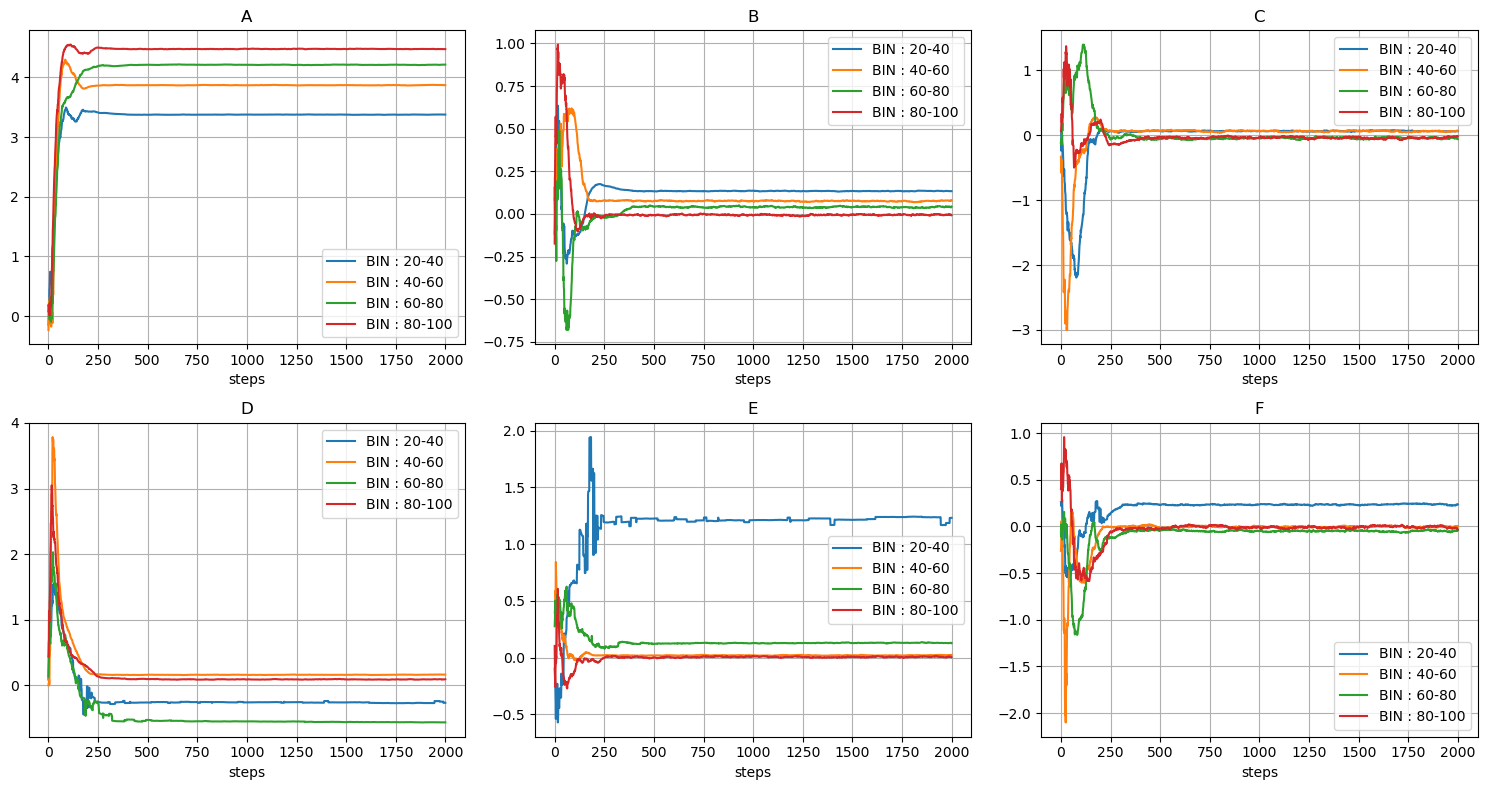

In [69]:
A, B, C, D, E, F = [], [], [], [], [], []
std_A, std_B, std_C, std_D, std_E, std_F = [], [], [], [], [], []

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)
A_ax = axes[0, 0]
B_ax = axes[0, 1]
C_ax = axes[0, 2]
D_ax = axes[1, 0]
E_ax = axes[1, 1]
F_ax = axes[1, 2]

for binn in range(len(table_bin)):
    list_mean_A, list_mean_B, list_mean_C, list_mean_D, list_mean_E, list_mean_F  = [], [], [], [], [], []
    list_A, list_B, list_C, list_D, list_E, list_F  = [], [], [], [], [], []
    print(binn/len(table_bin)*100)
    a, b = list_bin[binn]
    ndim, nwalkers = 6, 25
    ivar = 1. / np.random.rand(ndim)
    p0 = np.random.randn(nwalkers, ndim) # points de départ pour les walkers
    sampler = emcee.EnsembleSampler(nwalkers, ndim, _ln_L, args=[table_bin[binn], a, b])
    S = sampler.run_mcmc(p0, 2000)
    sample = sampler.get_chain()
    
    for step in range(len(sample)):
        list_mean_A.append(np.mean(sample[step, :, 0])) # récupération des paramètres
        list_mean_B.append(np.mean(sample[step, :, 1]))
        list_mean_C.append(np.mean(sample[step, :, 2]))
        list_mean_D.append(np.mean(sample[step, :, 3]))
        list_mean_E.append(np.mean(sample[step, :, 4]))
        list_mean_F.append(np.mean(sample[step, :, 5]))
        for walker in range(len(sample[step])):
            list_A.append(sample[step, walker, 0])
            list_B.append(sample[step, walker, 1])
            list_C.append(sample[step, walker, 2])
            list_D.append(sample[step, walker, 3])
            list_E.append(sample[step, walker, 4])
            list_F.append(sample[step, walker, 5])
    
    A.append(np.mean(list_A[len(list_A)//2:]))
    B.append(np.mean(list_B[len(list_B)//2:]))
    C.append(np.mean(list_C[len(list_C)//2:]))
    D.append(np.mean(list_D[len(list_D)//2:]))
    E.append(np.mean(list_E[len(list_E)//2:]))
    F.append(np.mean(list_F[len(list_F)//2:]))
    
    std_A.append(np.std(list_mean_A[len(list_mean_A)//2:]))
    std_B.append(np.std(list_mean_B[len(list_mean_B)//2:]))
    std_C.append(np.std(list_mean_C[len(list_mean_C)//2:]))
    std_D.append(np.std(list_mean_D[len(list_mean_D)//2:]))
    std_E.append(np.std(list_mean_E[len(list_mean_E)//2:]))
    std_F.append(np.std(list_mean_F[len(list_mean_F)//2:]))

    steps = np.arange(0, len(list_mean_A), 1)
    A_ax.plot(steps, list_mean_A, label = 'BIN : '+str(list_bin[binn][0])+'-'+str(list_bin[binn][1]))
    A_ax.set_title('A')
    A_ax.set_xlabel('steps')
    #A_ax.set_yscale('log')
    A_ax.grid(True)
    A_ax.legend()
    
    B_ax.plot(steps, list_mean_B, label = 'BIN : '+str(list_bin[binn][0])+'-'+str(list_bin[binn][1]))
    B_ax.set_title('B')
    B_ax.set_xlabel('steps')
    #B_ax.set_yscale('log')
    B_ax.grid(True)
    B_ax.legend()
    
    C_ax.plot(steps, list_mean_C, label = 'BIN : '+str(list_bin[binn][0])+'-'+str(list_bin[binn][1]))
    C_ax.set_title('C')
    C_ax.set_xlabel('steps')
    #C_ax.set_yscale('log')
    C_ax.grid(True)
    C_ax.legend()
              
    D_ax.plot(steps, list_mean_D, label = "BIN : "+str(list_bin[binn][0])+'-'+str(list_bin[binn][1]))
    D_ax.set_title('D')
    D_ax.set_xlabel('steps')
    #D_ax.set_yscale('log')
    D_ax.grid(True)
    D_ax.legend()
    
    E_ax.plot(steps, list_mean_E, label = 'BIN : '+str(list_bin[binn][0])+'-'+str(list_bin[binn][1]))
    E_ax.set_title('E')
    E_ax.set_xlabel('steps')
    #E_ax.set_yscale('log')
    E_ax.grid(True)
    E_ax.legend()
    
    F_ax.plot(steps, list_mean_F, label = 'BIN : '+str(list_bin[binn][0])+'-'+str(list_bin[binn][1]))
    F_ax.set_title('F')
    F_ax.set_xlabel('steps')
    #F_ax.set_yscale('log')
    F_ax.grid(True)
    F_ax.legend()

plt.tight_layout()
plt.show()

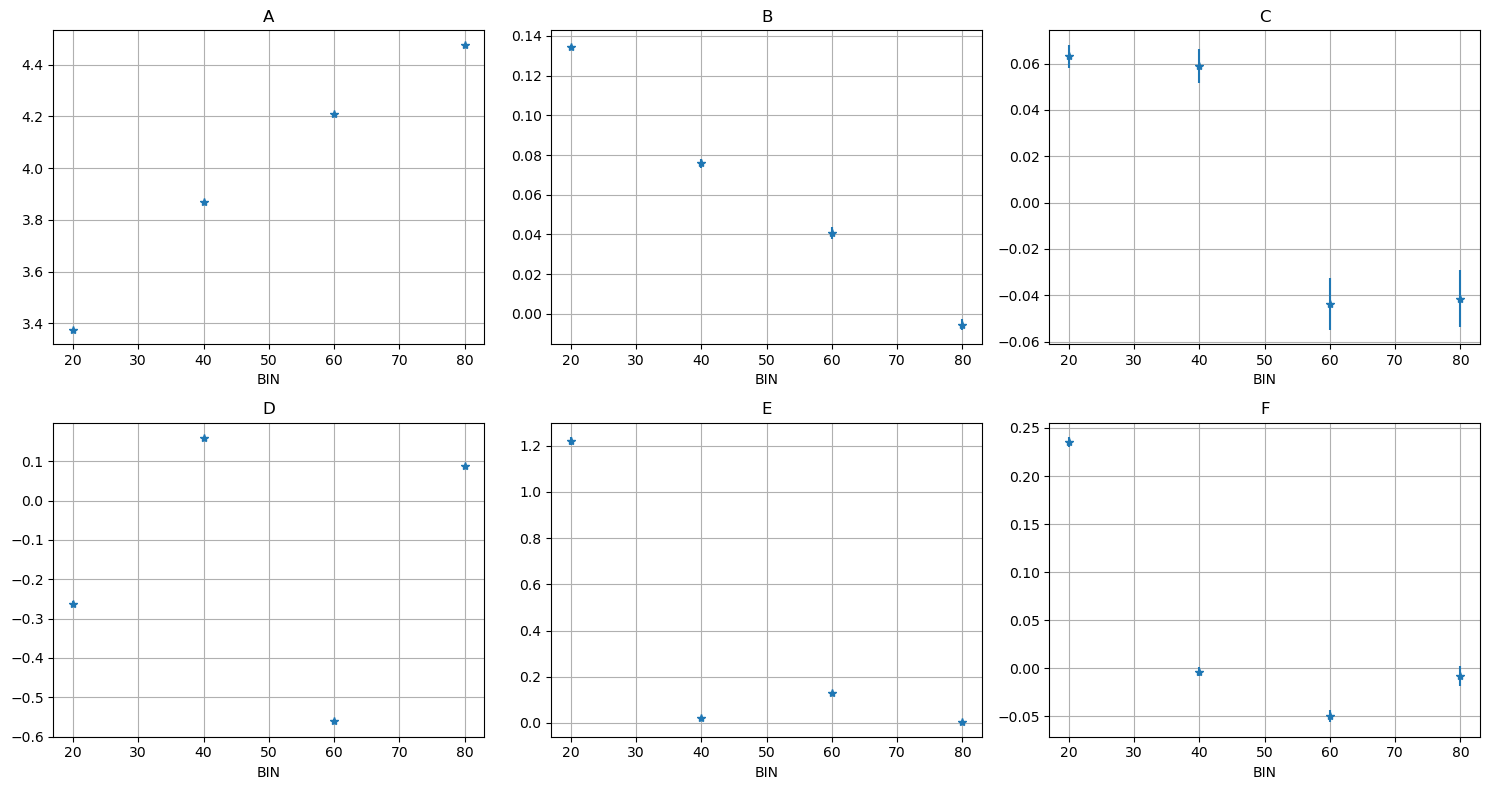

In [70]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)
A_ = axes[0, 0]
B_ = axes[0, 1]
C_ = axes[0, 2]
D_ = axes[1, 0]
E_ = axes[1, 1]
F_ = axes[1, 2]

A_.errorbar(list_bin[:,0], A, yerr = std_A, fmt = '*')
A_.set_title('A')
A_.set_xlabel('BIN')
A_.grid(True)

B_.errorbar(list_bin[:,0], B, yerr = std_B, fmt = '*')
B_.set_title('B')
B_.set_xlabel('BIN')
B_.grid(True)

C_.errorbar(list_bin[:,0], C, yerr = std_C, fmt = '*')
C_.set_title('C')
C_.set_xlabel('BIN')
C_.grid(True)

D_.errorbar(list_bin[:,0], D, yerr = std_D, fmt = '*')
D_.set_title('D')
D_.set_xlabel('BIN')
D_.grid(True)

E_.errorbar(list_bin[:,0], E, yerr = std_E, fmt = '*')
E_.set_title('E')
E_.set_xlabel('BIN')
E_.grid(True)

F_.errorbar(list_bin[:,0], F, yerr = std_F, fmt = '*')
F_.set_title('F')
F_.set_xlabel('BIN')
F_.grid(True)

plt.tight_layout()
plt.show()

In [56]:
print(E)

[np.float64(0.03183434837259072), np.float64(0.08813361166652502), np.float64(0.004492249285314782), np.float64(-0.528766373641562)]


0.0031242471134856563
[np.float64(0.07762930876735347), np.float64(0.3564458978057343), np.float64(0.0315848182446331), np.float64(2.6852596939720987)]


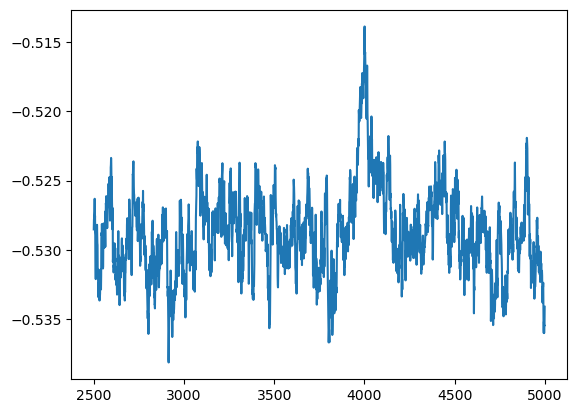

In [59]:
plt.plot(steps[len(steps)//2:], L)
print(np.std(list_mean_E[len(list_mean_E)//2:]))
print(std_E)